# Prae-1 (EPIC 211916756) transit analysis

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from core import *
from plots import AAOCW, AAPGW
def T14(p,a,k,I):
    return p/pi*arcsin( (1./a)*sqrt( ((1+k)**2 - (a*cos(I))**2) / (1-cos(I)**2)))

In [8]:
lpf = LPFunction()
chain_a = load('02d_tm.npz')['chains']
chain_b = load('01a_wn_logg481.npz')['chains']
fca = chain_a.reshape([-1,lpf.ps.ndim])
fcb = chain_b.reshape([-1,lpf.ps.ndim])
mpa = median(fca, 0)
mpb = median(fcb, 0)

## Create the dataframe

In [16]:
pd.set_option('display.precision',4)
def create_df(fc):
    df = pd.DataFrame(data=fc.copy(), columns=lpf.ps.names)
    df['tcc'] = df.tc - floor(df.tc.mean())
    df['pc'] = df.p - 10
    df['ecc'] = df.secw**2+df.sesw**2
    df['w'] = arctan2(df.sesw, df.secw)
    df['e'] *= 1e6
    df['k'] = sqrt(df.k2)
    df['a'] = as_from_rhop(df.rho, df.p)
    df['I'] = np.rad2deg(arccos(df.b/df.a))
    df['u'] = 2*sqrt(df.q1)*df.q2
    df['v'] = sqrt(df.q1)*(1-2*df.q2)
    df['T14'] = 24*T14(df.p, df.a, df.k, radians(df.I))
    df = df.drop(['k2','q1','q2'], axis=1)
    return df

dfa = create_df(fca)
dfb = create_df(fcb)
dfa.describe()

,tc,p,rho,b,e,c,secw,sesw,tcc,pc,ecc,w,k,a,I,u,v,T14
count,14000.0000,14000.0000,14000.0000,1.4000e+04,14000.0000,1.4000e+04,14000.0000,14000.0000,14000.0000,14000.0000,1.4000e+04,14000.0000,14000.0000,14000.0000,14000.0000,14000.0000,14000.0000,14000.0000
mean,2317.8786,10.1344,5.4079,4.0121e-01,939.2100,1.0001e+00,-0.0149,-0.2137,0.8786,0.1344,3.5874e-01,-0.7640,0.0772,29.5672,89.1246,0.9827,-0.2080,2.5954
std,0.0016,0.0004,3.3085,2.4965e-01,26.9082,3.8452e-05,0.4435,0.3408,0.0016,0.0004,2.4082e-01,1.6764,0.0071,6.2653,0.6893,0.3913,0.3699,0.4945
min,2317.8723,10.1326,0.4400,4.6941e-06,850.8017,9.9996e-01,-0.7997,-0.7991,0.8723,0.1326,7.4165e-06,-3.1415,0.0606,13.3684,86.0047,0.0014,-0.9893,1.0247
25%,2317.8776,10.1341,2.9125,1.8867e-01,920.8347,1.0001e+00,-0.3939,-0.4986,0.8776,0.1341,1.5785e-01,-2.2432,0.0725,25.0991,88.7347,0.7151,-0.4872,2.2631
50%,2317.8786,10.1344,4.6265,3.8519e-01,938.5744,1.0001e+00,-0.0160,-0.2663,0.8786,0.1344,3.2579e-01,-0.9366,0.0755,29.2870,89.2924,0.9939,-0.2547,2.6016
75%,2317.8797,10.1347,7.1546,5.9269e-01,956.8663,1.0002e+00,0.3666,0.0308,0.8797,0.1347,5.3141e-01,0.1795,0.0799,33.8680,89.6664,1.2622,0.0230,2.8645
max,2317.8847,10.1362,14.9980,9.8994e-01,1055.8070,1.0003e+00,0.7998,0.7734,0.8847,0.1362,9.4686e-01,3.1407,0.1116,43.3427,90.0000,1.9850,0.9723,6.0707


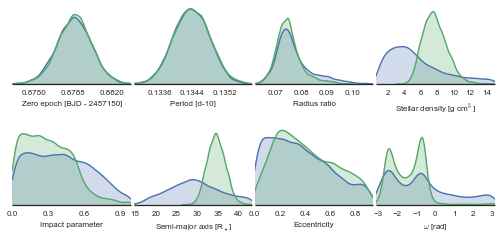

In [60]:
sb.set_context('paper')
fig,ax = subplots(2,4, figsize=(AAPGW,AAOCW))

pars = 'tcc pc k rho b a ecc w'.split()
labels = ('Zero epoch [BJD - {:7d}], Period [d-10], Radius ratio, '
          'Stellar density [g cm$^3$], '
          'Impact parameter, Semi-major axis [R$_\star$], Eccentricity, $\omega$ [rad]'.format(bjdref+2317).split(', '))
             
for i,(par,label) in enumerate(zip(pars,labels)):
    sb.kdeplot(dfa[par], shade=True, ax=ax.flat[i], legend=False)
    sb.kdeplot(dfb[par], shade=True, ax=ax.flat[i], legend=False)
    setp(ax.flat[i], xlabel=label, xlim=percentile(dfa[par], [0.05,99.95]))

sb.despine(fig, left=True)
setp(sum([a.get_yticklabels() for a in ax.flat]), visible=False)
[a.xaxis.label.set_size(8) for a in ax.flat] 

setp(ax[0,0], xticks=linspace(0.875,0.882, 3))
setp(ax[1,0], xticks=linspace(0,0.9, 4))
setp(ax[0,1], xticks=np.round(percentile(dfa.pc, [3,50,97]), 4))

fig.tight_layout()
fig.subplots_adjust(wspace=0.02)
fig.savefig('basic_parameter_estimates_wn_pub.pdf')

In [ ]:
a.xaxis.label.set_size

## Plot the light curve

In [141]:
lpf_plot = LPFunction(linspace(mp[0]-0.03*mp[1], mp[0]+0.32*mp[1], 1500), ones(1500), mp[0], mp[1])

pvs = permutation(fc)[:1000]
mphase_o_d = 24*mp[1]*(fold(lpf.time, mp[1], mp[0], 0.5, normalize=True) - 0.5)
phases_m_d = 24*mp[1]*array([fold(lpf_plot.time, pv[1], pv[0], 0.5, normalize=True) - 0.5 for pv in pvs])
mphase_m_d = mean(phases_m_d, 0)

flux_pr = array([lpf_plot.compute_lc_model(pv) for pv in pvs])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

flux_mo = median(array([lpf.compute_lc_model(pv) for pv in pvs]), 0)

**NOTE:** The orbital period is close to a multiple of Kepler long cadence exposure duration...

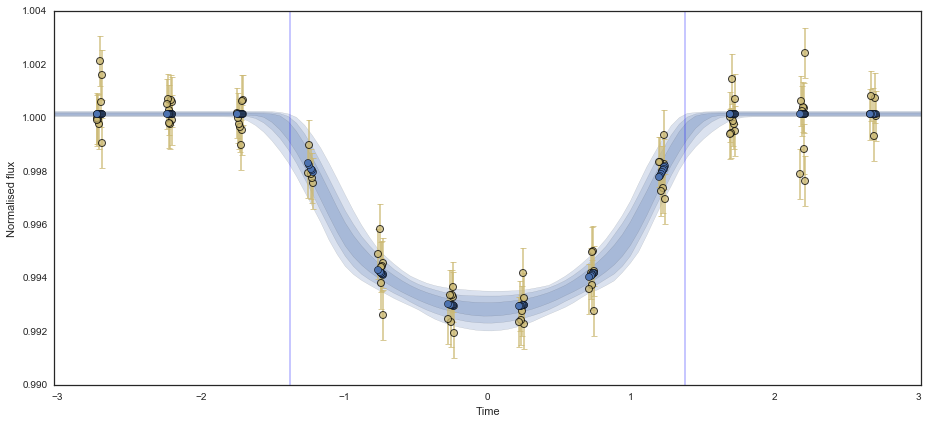

In [144]:
with sb.axes_style('white'):
    fig, ax = subplots(1,1, figsize=(13,6))
    hT14 = 0.5*median(df.T14)
    cp = sb.color_palette()
    sids = argsort(mphase_m_d)
    ax.errorbar(mphase_o_d, lpf.flux_o, mp[5], fmt='o', c=cp[4], alpha=0.75, markeredgecolor='k', markeredgewidth=1)
    [ax.fill_between(mphase_m_d[sids],*flux_pc[i:i+2,sids],alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
    #ax.plot(mphase_m_d[sids], flux_pc[0,sids], c=cp[0], lw=1, ls=':')
    ax.plot(mphase_o_d, flux_mo, 'o', markeredgecolor='k', markeredgewidth=0.5)
    #ax.plot(mphase_o_d, lpf.flux_o, '.', c=cp[4], alpha=0.75)
    ax.axvline( hT14, alpha=0.25)
    ax.axvline(-hT14, alpha=0.25)
    setp(ax, xlim=(-3.02,3.02), ylim=(0.99,1.004),xlabel='Time', ylabel='Normalised flux')
    fig.tight_layout()
    fig.savefig('lc_model_wn.png')

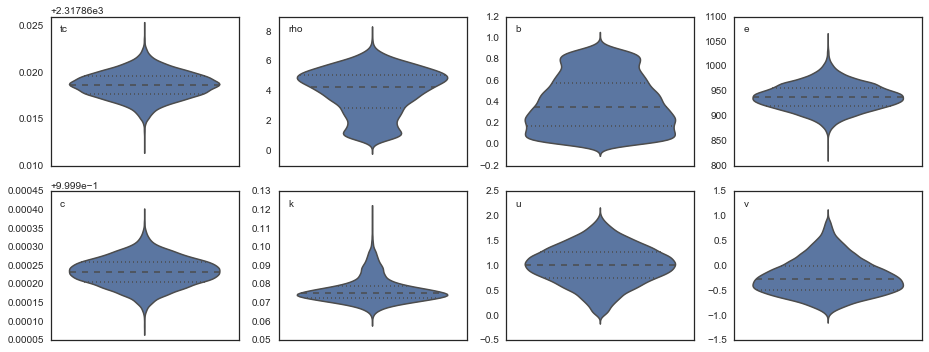

In [15]:
with sb.axes_style('white'):
    fig, axs = subplots(2,4, figsize=(13,5))
    pars = 'tc rho b e c k u v'.split()
    [sb.violinplot(df[p], ax=axs.flat[i]) for i,p in enumerate(pars)]
    [axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
    setp(axs, xticks=[], ylabel='')
    fig.tight_layout()

In [146]:
def ms(df,p):
    p = array(percentile(df[p], [50,16,84]))
    return p[0], abs(p[1:]-p[0]).mean()

def create_row(df,pars):
    return ('<tr>'+
            ''.join(['<td>{:5.4f} &plusmn; {:5.4f}</td>'.format(*ms(df,p)) for p in pars])+
            '</tr>')

def create_table(df):    
    pars = 'tc p rho b k T14 a I'.split()
    return ('<table style="width:100%">'+
            ''.join(['<th>{:}</th>'.format(p) for p in pars])+
            create_row(df,pars)+
            '</table>')

In [18]:
display(HTML(create_table(df)))

2317.8786 ± 0.0014,10.1344 ± 0.0004,4.1400 ± 1.7367,0.3703 ± 0.2950,0.0755 ± 0.0064,2.7590 ± 0.1623,28.2210 ± 4.4826,89.2581 ± 0.8139


In [147]:
print create_table(df)

<table style="width:100%"><th>tc</th><th>p</th><th>rho</th><th>b</th><th>k</th><th>T14</th><th>a</th><th>I</th><tr><td>2317.8787 &plusmn; 0.0014</td><td>10.1344 &plusmn; 0.0004</td><td>4.2522 &plusmn; 1.6465</td><td>0.3492 &plusmn; 0.2873</td><td>0.0753 &plusmn; 0.0059</td><td>2.7522 &plusmn; 0.1539</td><td>28.4745 &plusmn; 4.1293</td><td>89.3034 &plusmn; 0.7579</td></tr></table>


In [19]:
HTML(create_table(df))

2317.8787 ± 0.0014,10.1344 ± 0.0004,4.0891 ± 1.8785,0.3862 ± 0.3146,0.0758 ± 0.0073,2.4863 ± 0.1164,28.1045 ± 5.0655,89.2200 ± 0.9257
